# 1D Spectrum or Curve

**Suhas Somnath**

10/12/2018

**This example illustrates how a 1 dimensional curve or spectrum would be represented in the Universal Spectroscopy and
Imaging Data (USID) schema and stored in a Hierarchical Data Format (HDF5) file, also referred to as the h5USID file.**

This document is intended as a supplement to the explanation about the [USID model](../../usid_model.html)

Please consider downloading this document as a Jupyter notebook using the button at the bottom of this document.

Prerequisites:
--------------
We recommend that you read about the [USID model](../../usid_model.html)

We will be making use of the ``pyUSID`` package at multiple places to illustrate the central point. While it is
recommended / a bonus, it is not absolutely necessary that the reader understands how the specific ``pyUSID`` functions
work or why they were used in order to understand the data representation itself.
Examples about these functions can be found in other documentation on pyUSID and the reader is encouraged to read the
supplementary documents.

### Import all necessary packages
The main packages necessary for this example are ``h5py``, ``matplotlib``, and ``sidpy``, in addition to ``pyUSID``:

In [1]:
import subprocess
import sys
import os
import matplotlib.pyplot as plt
from warnings import warn
import h5py

%matplotlib inline

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install('wget')
    import wget

# Finally import pyUSID.
try:
    import pyUSID as usid
    import sidpy
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import sidpy
    import pyUSID as usid

Download the dataset
---------------------
We will be working on a **Force-Distance Curve** obtained from an Atomic Force Microscope (AFM) in this example.
As mentioned earlier, this dataset is available on the USID repository and can be accessed directly as well.
Here, we will simply download the file using ``wget``:



In [2]:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/AFM_Force_Curve.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)

Open the file
-------------
Lets open the file and look at its contents using
[sidpy.hdf_utils.print_tree()](https://pycroscopy.github.io/sidpy/notebooks/03_hdf5/hdf_utils_read.html#print_tree())



In [3]:
h5_file = h5py.File(h5_path, mode='r')
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


Clearly, this file contains a single `Measurement` which has a single `[Channel](../../usid_model.html#channels).
We can access the [Main Dataset](../../usid_model.html#main-datasets) where all the information is located in
multiple ways. Given that this file contains just a single ``Main Dataset`` we can conveniently use the [pyUSID.hdf_utils.get_all_main()]( https://pycroscopy.github.io/pyUSID/_autosummary/pyUSID.io.hdf_utils.simple.get_all_main.html#pyUSID.io.hdf_utils.simple.get_all_main) function.



In [4]:
h5_main = usid.hdf_utils.get_all_main(h5_file)[-1]
print(h5_main)

<HDF5 dataset "Raw_Data": shape (1, 2045), type "<f4">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Deflection (m) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 1 
Spectroscopic Dimensions: 
	Z - size: 2045
Data Type:
	float32


Here, ``h5_main`` is a [USIDataset](../user_guide/usi_dataset.html), which can be thought of as a supercharged
HDF5 Dataset that is not only aware of the contents of the plain ``Raw_Data`` dataset but also its links to the
[Ancillary Datasets](../../usid_model.html#ancillary-datasets) that make it a ``Main Dataset``.

Understanding Dimensionality
----------------------------
What is more is that the above print statement shows that this ``Main Dataset`` has one ``Position Dimension`` - ``X``
which was varied over a single value and a single ``Spectroscopic Dimension`` - ``Z`` which was varied several times.
Therefore, this dataset is really just a simple 1D dataset where the sole dimension is ``Z``.

The original shape of this dataset would be ``(2045,)``. In USID, this shape needs to (explicitly) include a position
axis to state that the measurement was acquired over a single position / location. Therefore, the shape of this data
in USID would be ``(1, 2045)``

Visualize the Main Dataset
--------------------------
Now lets visualize the contents within this ``Main Dataset`` using the ``USIDataset's`` built-in
[visualize()](../user_guide/usi_dataset.html#Interactive-Visualization) function. Clearly, this dataset is indeed
a simple 1D dataset.



(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'/Measurement_000/Channel_000/Raw_Data'}, xlabel='Z (m) x $10^{-6}$', ylabel='Deflection (m) x $10^{-7}$'>)

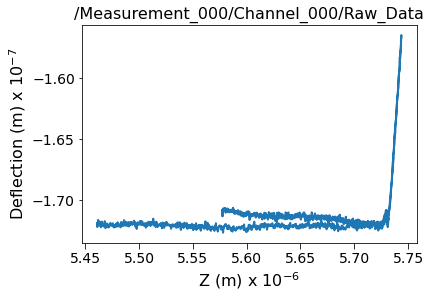

In [5]:
sidpy.plot_utils.use_nice_plot_params()
h5_main.visualize()

Ancillary Datasets
------------------
As mentioned in the documentation on USID, ``Ancillary Datasets`` are required to complete the information for any
dataset. Specifically, these datasets need to provide information about the values against which measurements were
acquired, in addition to explaining the original dimensionality (1 in this case) of the original dataset. Let's look
at the ancillary datasets and see what sort of information they provide. We can access the ``Ancillary Datasets``
linked to the ``Main Dataset`` (``h5_main``) just like a property of the object.

Ancillary Position Datasets
---------------------------
Given that this force-distance curve was acquired at a single position, the ancillary position datasets become trivial
as seen below. Note that we access the ``Ancillary Datasets`` as properties of ``h5_main``:



In [6]:
print('Position Indices:')
print('-------------------------')
print(h5_main.h5_pos_inds)
print('containing:')
print(h5_main.h5_pos_inds[()])
print('\nPosition Values:')
print('-------------------------')
print(h5_main.h5_pos_vals)
print('containing:')
print(h5_main.h5_pos_vals[()])

Position Indices:
-------------------------
<HDF5 dataset "Position_Indices": shape (1, 1), type "<u4">
containing:
[[0]]

Position Values:
-------------------------
<HDF5 dataset "Position_Values": shape (1, 1), type "<f4">
containing:
[[1.]]


Note that as explained above, these position datasets only contain a single value for the `fake` position axis over
which the data was collected. Regardless of the fact that the data was collected at a single location, the Position
datasets should be two dimensional in shape (one element in each axis) according the USID rules.

Regardless of how uninformative the Position Datasets seem for this specific example, they are still necessary for the
``Raw_Data`` dataset to be a ``Main Dataset``.

### Attributes associated with the Position Indices Dataset
Just looking at the shape and values of the Position ancillary datasets does not provide all the information.
Recall that the ancillary datasets need to have some mandatory attributes like ``labels`` and ``units`` that
describe the quantity and units for each of the dimensions:



In [7]:
for key, val in sidpy.hdf_utils.get_attributes(h5_main.h5_pos_inds).items():
    print('{} : {}'.format(key, val))

X : <HDF5 region reference>
labels : ['X']
units : ['a. u.']


Ancillary Spectroscopic Datasets
--------------------------------
Unlike the Position ``Ancillary Datasets`` that are not very descriptive for this example, the Spectroscopic Datasets
are very important since these datasets explain how the independent variable, ``Z`` was varied.

Looking at the Spectroscopic HDF5 datasets
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [8]:
print('Spectroscopic Indices:')
print('-------------------------')
print(h5_main.h5_spec_inds)
print('\nSpectroscopic Values:')
print('-------------------------')
print(h5_main.h5_spec_vals)

Spectroscopic Indices:
-------------------------
<HDF5 dataset "Spectroscopic_Indices": shape (1, 2045), type "<u4">

Spectroscopic Values:
-------------------------
<HDF5 dataset "Spectroscopic_Values": shape (1, 2045), type "<f4">


Here, the first index in the shape of both datasets indicates that there is a single Spectroscopic Dimension.
The second index in the shape of the datasets indicates that this single dimension was varied over several values.

### Attributes within the Spectroscopic Indices Dataset
Again, the attributes of Spectroscopic Datasets show mandatory information about the Spectroscopic dimensions such as
the quantity (``labels``) and ``units``:



In [9]:
for key, val in sidpy.hdf_utils.get_attributes(h5_main.h5_spec_inds).items():
    print('{} : {}'.format(key, val))

Z : <HDF5 region reference>
labels : ['Z']
units : ['m']


### Visualize the contents of the Spectroscopic Datasets
Observe the single curve that is associated with the single spectroscopic variable ``Z``. Also note that the contents
of the ``Spectroscopic Indices`` dataset are just a linearly increasing set of numbers starting from ``0`` according
to the definition of the Indices datasets which just count the nth value of independent variable that was varied.
The ``Spectroscopic Values`` dataset clearly shows that this variable varies non-linearly and could not have been
represented using trivial bookkeeping. **This ability to allow dimensions to vary in arbitrary manners is one of the
biggest strengths of USID over other alternatives.**



Text(0.5, 1.05, 'Ancillary Spectroscopic Datasets')

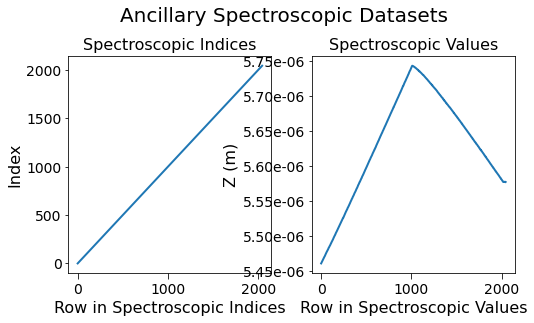

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for axis, data, title, y_lab in zip(axes.flat,
                                    [h5_main.h5_spec_inds[()].T, h5_main.h5_spec_vals[()].T],
                                    ['Spectroscopic Indices', 'Spectroscopic Values'],
                                    ['Index', h5_main.spec_dim_descriptors[0]]):
    axis.plot(data)
    axis.set_title(title)
    axis.set_xlabel('Row in ' + title)
    axis.set_ylabel(y_lab)

sidpy.plot_utils.use_scientific_ticks(axis, is_x=False)
fig.suptitle('Ancillary Spectroscopic Datasets', y=1.05)
# fig.tight_layout()

Clean up
--------
Finally lets close the HDF5 file.



In [11]:
h5_file.close()

Here, we will even delete the HDF5 file. Please comment out this line if you want to look at the HDF5 file using
software like HDFView.



In [12]:
os.remove(h5_path)